# <center> TP3 : Reconnaissance de Formes </center>

### <center> Appariement d'images à partir de leurs descripteurs </center>



## BERNEAUD Noah 21900500

**Objectif du TP :** Appariement (Couplage) à partir de points d'intérêt pour comprendre les nuances de différentes méthodes de détection de points clés et de métriques d'appariement.


## I. Points d'intérêt :

Nous avons vu comment les filtres peuvent être utilisés pour trouver des contours dans une image. Cependant, nous pouvons également utiliser des filtres pour détecter des caractéristiques dans une image. Dans le contexte de l'odométrie visuelle, l'objectif est de trouver et d'extraire des caractéristiques d'une image que nous pouvons utiliser comme modèles dans une autre image. De cette manière, nous pouvons faire correspondre les caractéristiques entre deux images et calculer le mouvement relatif entre elles.

La correspondance des points clés peut également être utilisée pour d'autres applications telles que la Composition de Panorama, la Reconnaissance d'Objets, la Reconstruction 3D ou la reconnaissance de lieu. Le problème est toujours le même : étant donné une image, nous voulons faire correspondre une autre image de la même scène mais prise dans des conditions environnementales différentes.

Il existe plusieurs méthodes de détection de points clés (ou points d'intérêt) dans le domaine de la vision par ordinateur. Ces méthodes varient en termes de robustesse, de rapidité, d'invariance aux transformations, etc. 

La démarche est la suivante :

    - a) Convertir l'image en niveaux de gris

    - b) Initialiser le détecteur et le descripteur en fonction du type spécifié
        
        detecteur   = initialiser_detecteur(type_detecteur)     ==> par exemple  detecteur  =  cv2.ORB_create()  
        descripteur = initialiser_descripteur(type_descripteur) ==> par exemple  descripteur =  cv2.ORB_create()  
    
    - c)  Détection des points clés
    
        points_cles = detecteur.detect(image_grise, None)

    - d)  Calcul des descripteurs
        
        _, descripteurs = descripteur.compute(image_grise, points_cles)
    
    
    - Remarque : On peut utiliser le détecteur pour détecter les points clés et calculer les descripteurs
        
        __, descripteur = detecteur.detectAndCompute(Imge_grise, None)




In [1]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import euclidean, cdist    #.... autres distances
from scipy.optimize import linear_sum_assignment
from scipy.signal import convolve2d
import ipywidgets as widgets
from ipywidgets import interact, interactive_output
from IPython.display import clear_output
from skimage.transform import AffineTransform, warp


# I. Extraction de points d'intérêt

OpenCV offre une multitude de points d'intérêts et de descripteurs. 

On peut par exemple utiliser les points d'intérêts fournis par goodFeaturesToTrack ou les points orb. Creez un répertoire images que vous peuplerez de plusieurs images. Puis essayer d'afficher les points détecté par ORB et par le détecteur goodFeaturesToTrack. Dans les deux cas on limitera le nombre de points à 50. 

Nombre de points clés selon Orb :  50
Nombre de points clés selon GoodFeaturesToTrack :  50


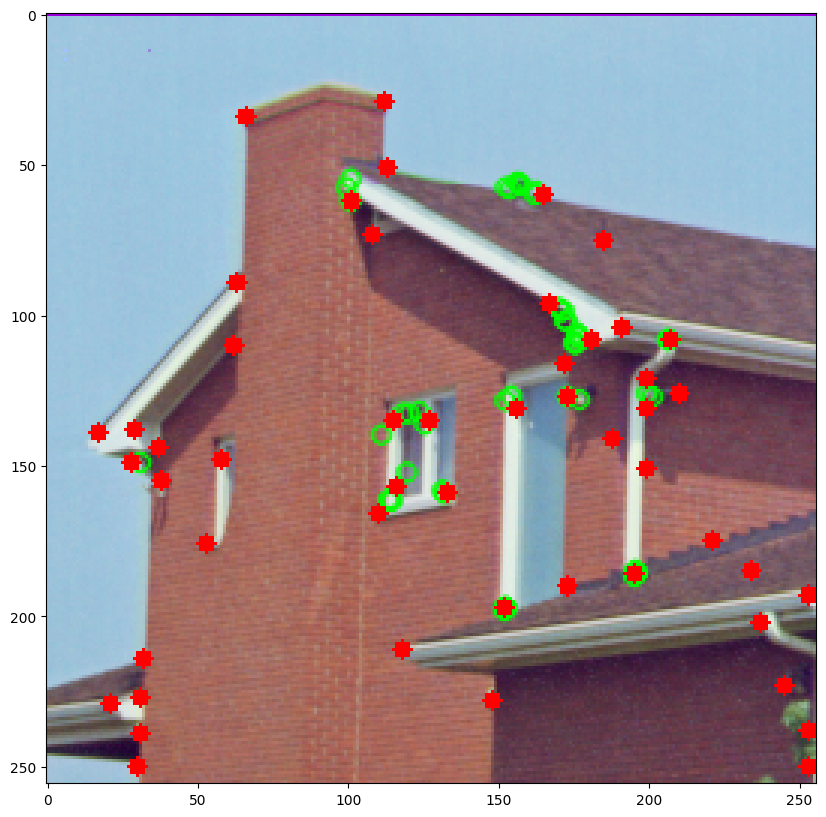

In [2]:
image = cv2.imread('images/house1.ppm')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

detecteur = cv2.ORB_create(nfeatures=50)
descripteur = cv2.ORB_create(nfeatures=50)

points_cles = detecteur.detect(gray, None)
points_cles, descripteurs = descripteur.compute(gray, points_cles)

image = cv2.drawKeypoints(image, points_cles, None, color=(0,255,0), flags=0)

print("Nombre de points clés selon Orb : ", len(points_cles))

#Avec GoodFeaturesToTrack
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

points_cles = cv2.goodFeaturesToTrack(gray, 50, 0.01, 10)
print("Nombre de points clés selon GoodFeaturesToTrack : ", len(points_cles))
for p in points_cles:
    x = int(p[0][0])
    y = int(p[0][1])
    cv2.circle(image, (x,y), 3, (0,0,255), -1)

plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1])



In [3]:
#plt.rcParams['figure.figsize'] = (10, 5)
def plot(image1,image2,titre):
    # Afficher les images avec les coins Harris détectés
    plt.subplot(1, 2, 1), plt.imshow(image1, cmap='gray')
    plt.title(titre+"-Image1"), plt.xticks([]), plt.yticks([])
    plt.subplot(1, 2, 2), plt.imshow(image2, cmap='gray')
    plt.title(titre+"-Image2"), plt.xticks([]), plt.yticks([])
    plt.show()

### A Faire :
-  Réaliser un programme interactif qui permet de :
    - Choisir le typed de détecteur
    - Selectionner les paramètres du déteceur

  

In [4]:
def extraire_descripteurs(image_grise, type_detecteur='SIFT', pourcentage=0.1):
      # En fonction du type de détecteur / descripteur, renvoyer la liste des points clés et des descripteurs
      if type_detecteur == 'HARRIS':
            harris = cv2.cornerHarris(image_grise, 2, 3, 0.04)
            points_cles = np.argwhere(harris > 0.01 * harris.max())
            points_cles = [cv2.KeyPoint(int(p[1]), int(p[0]), 1) for p in points_cles]      
            descripteurs = None
      elif type_detecteur == 'FAST':
            detecteur = cv2.FastFeatureDetector_create()
            descripteurs = None
            points_cles = detecteur.detect(image_grise, None)
      elif type_detecteur == 'ORB':
            detecteur = cv2.ORB_create(nfeatures=50)
            descripteur = cv2.ORB_create(nfeatures=50)
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'KAZE':
            detecteur = cv2.KAZE_create()
            descripteur = cv2.KAZE_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'AKAZE':
            detecteur = cv2.AKAZE_create()
            descripteur = cv2.AKAZE_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'BRISK':
            detecteur = cv2.BRISK_create()
            descripteur = cv2.BRISK_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'SIFT':
            detecteur = cv2.SIFT_create()
            descripteur = cv2.SIFT_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'GFTT':
            detecteur = cv2.GFTTDetector_create()
            descripteur = None
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == 'SURF':
            detecteur = cv2.SURF_create()
            descripteur = cv2.SURF_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      elif type_detecteur == "SHI_TOMASI":
            points_cles = cv2.goodFeaturesToTrack(image_grise, 50, 0.01, 10)
            points_cles = [cv2.KeyPoint(int(p[0][0]), int(p[0][1]), 1) for p in points_cles]
            descripteurs = None
      elif type_detecteur == "MOPS":
            detecteur = cv2.MOPS_create()
            descripteur = cv2.MOPS_create()
            points_cles = detecteur.detect(image_grise, None)
            _, descripteurs = descripteur.compute(image_grise, points_cles)
      else:
            raise ValueError("Invalid type_detecteur value. Please choose from the given options.")
      
      # On ne garde qu'un pourcentage des points clés
      points_cles = points_cles[:int(pourcentage * len(points_cles))]
      if descripteurs is not None:
            descripteurs = descripteurs[:int(pourcentage * len(descripteurs))]

      return points_cles, descripteurs


In [5]:
import cv2
import ipywidgets as widgets
from ipywidgets import interactive_output
import matplotlib.pyplot as plt

def Test_Points_Interet(image_grise, type_detecteur='SIFT', pourcentage=0.1):
    points_cles, descripteurs = extraire_descripteurs(image_grise, type_detecteur, pourcentage)

    print("Nombre de points clés détectés : ", len(points_cles))

    image = cv2.drawKeypoints(image_grise, points_cles, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(10, 10))
    plt.imshow(image[:, :, ::-1])
    plt.show()

    if descripteurs is not None:
        print("Taille du descripteur : ", descripteurs.shape)
        # histogramme des descripteurs
        plt.figure(figsize=(5, 5))
        plt.hist(descripteurs.ravel(), 256, [0, 256])
        plt.show()


image = cv2.imread('images/house2.ppm')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

type_widget = widgets.Dropdown(
    options=["HARRIS", "SHI_TOMASI", "FAST", "ORB", "KAZE", "AKAZE", "BRISK", "SIFT", "GFTT", "MOPS"],
    value="SIFT",
    description="Type"
)

pourcentage_widget = widgets.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=0.1,
    description="Pourcentage"
)

output = interactive_output(Test_Points_Interet, {'image_grise': widgets.fixed(image), 'type_detecteur': type_widget, 'pourcentage': pourcentage_widget})

widget_container = widgets.VBox([type_widget, pourcentage_widget])

display(widget_container, output)


Output()

In [6]:
def matching(image1,image2,kp_list1,kp_list2):
    correspondances = []

    kp_list2 = list(kp_list2)


    for p1 in kp_list1:
        distances = []
        x1, y1 = p1.pt
        min = np.inf
        if(len(kp_list2) == 0):
            break
        
        for p2 in kp_list2:
                x2, y2 = p2.pt
                euclidean_distance = euclidean((x1, y1), (x2, y2))
                similarité = np.linalg.norm(image1[int(y1), int(x1)] - image2[int(y2), int(x2)])
                dist = (euclidean_distance + similarité)
                if dist < min:
                    min = dist
                    point_min = p2
        correspondances.append([p1, point_min])
        kp_list2.remove(point_min)
        point_min = None
            
    return correspondances

def trace(img1,img2,kp_list1,kp_list2,correspondances):
    hauteur, largeur = img1.shape[:2]
    img2_resized = cv2.resize(img2, (largeur, hauteur))

    for p1, p2 in correspondances:
        x1, y1 = p1.pt
        x2, y2 = p2.pt
        cv2.circle(img1, (int(x1), int(y1)), 1, (0, 0, 255), -1)
        cv2.circle(img2_resized, (int(x2), int(y2)), 1, (0, 0, 255), -1)


    img_combine = np.hstack((img1, img2_resized))
    for p1, p2 in correspondances:
        x1, y1 = p1.pt
        x2, y2 = p2.pt
        cv2.line(img_combine, (int(x1), int(y1)), (int(x2) + largeur, int(y2)), (255, 0, 0), 1)
    

    # Afficher le résultat
    plt.imshow(cv2.cvtColor(img_combine, cv2.COLOR_BGR2RGB))
    plt.title("Appariement de points d'intérêt entre les deux images")
    plt.axis('off')  # Désactiver les axes
    plt.show()


/var/folders/xw/6533cp092nl4j8x1b0rtnlpm0000gn/T/ipykernel_53065/1879209310.py:17: RuntimeWarning: overflow encountered in scalar subtract
  similarité = np.linalg.norm(image1[int(y1), int(x1)] - image2[int(y2), int(x2)])


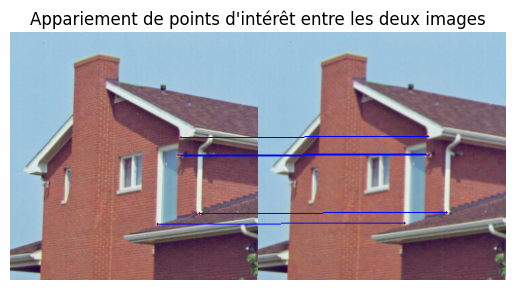

In [7]:
img1 = cv2.imread('images/house1.ppm')
img2 = cv2.imread('images/house2.ppm')

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
points_cles1, descripteurs1 = extraire_descripteurs(img1_gray, type_detecteur='ORB')
points_cles2, descripteurs2 = extraire_descripteurs(img2_gray, type_detecteur='ORB')
correspondances = matching(img1_gray,img2_gray,points_cles1,points_cles2)

trace(img1,img2,points_cles1,points_cles2,correspondances)  
    





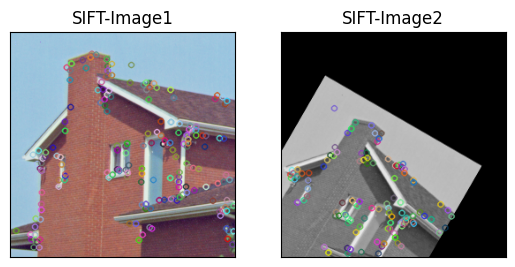

Nombre de points clés détectés pour l'image 1 : 206
Nombre de points clés détectés pour l'image 2 : 127


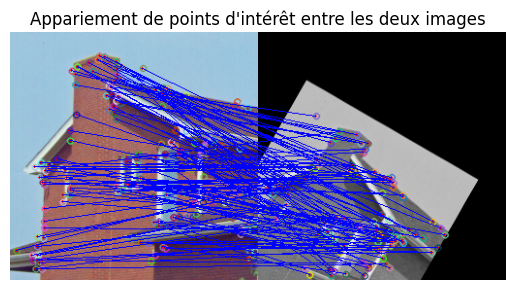

In [8]:
from skimage.transform import AffineTransform, warp

image1 = cv2.imread('images/house1.ppm')
image1_grise = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)


scale = 0.8
rotation = 30
translation = (50, 50)

transform = AffineTransform(scale=(scale, scale), rotation=np.deg2rad(rotation), translation=translation)

image2 = warp(image1_grise, transform.inverse)

image2 = (image2 * 255).astype(np.uint8)



detecteur = cv2.SIFT_create()

points_cles_image1, descripteurs_image1 = detecteur.detectAndCompute(image1_grise, None)
points_cles_image2, descripteurs_image2 = detecteur.detectAndCompute(image2, None)

image2 = cv2.drawKeypoints(image2, points_cles_image2, None, flags=0)
image1 = cv2.drawKeypoints(image1, points_cles_image1, None, flags=0)

plot(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB),cv2.cvtColor(image2, cv2.COLOR_BGR2RGB),'SIFT')

# Nombre de points pour chaque image
print(f"Nombre de points clés détectés pour l'image 1 : {len(points_cles_image1)}")
print(f"Nombre de points clés détectés pour l'image 2 : {len(points_cles_image2)}")

trace(image1,image2,points_cles1,points_cles2,matching(image1,image2,points_cles_image1,points_cles_image2))
    

In [9]:
def rotation_translation(image, angle,translation,scale):
    transform = AffineTransform(scale=(scale,scale), rotation=np.deg2rad(angle), translation=(translation, translation))
    image2 = warp(image, transform.inverse)
    image2 = (image2 * 255).astype(np.uint8)
    return image2

def Test_Points_Interet1(repertoire_images, image1_name, image2_name, type_detecteur, pourcentage,angle, translation, scale):
    image1_path = os.path.join(repertoire_images, image1_name)
    image2_path = os.path.join(repertoire_images, image2_name)

    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    image2 = rotation_translation(image2, angle,translation,scale)

    image1_grise = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_grise = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    points_cles1, descripteurs1 = extraire_descripteurs(image1_grise, type_detecteur, pourcentage)
    points_cles2, descripteurs2 = extraire_descripteurs(image2_grise, type_detecteur,pourcentage)

    image1 = cv2.drawKeypoints(image1, points_cles1, None, flags=0)
    image2 = cv2.drawKeypoints(image2, points_cles2, None, flags=0)
    plot(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB),cv2.cvtColor(image2, cv2.COLOR_BGR2RGB),type_detecteur)

    match = matching(image1_grise,image2_grise,points_cles1,points_cles2)
    trace(image1,image2,points_cles1,points_cles2,match)

    print("Nombre de points - Image1 : ", len(points_cles1))
    print("Nombre de points - Image2 : ", len(points_cles2))
    

repertoire_images = 'images'
image_names_list1 = os.listdir(repertoire_images)
image_names_list2 = os.listdir(repertoire_images)

repertoire_widget = widgets.Text(
    value=repertoire_images,
    description="Répertoire"
)

image_widget_list1 = widgets.Dropdown(
    options=image_names_list1,
    value=image_names_list1[0],
    description="Image 1"
)

image_widget_list2 = widgets.Dropdown(
    options=image_names_list2,
    value=image_names_list2[0],
    description="Image 2"
)

type_widget = widgets.Dropdown(
    options=["HARRIS", "SHI_TOMASI", "FAST", "ORB", "MOPS", "KAZE", "AKAZE", "BRISK", "BRIEF", "SIFT", "GFTT"],
    value="SIFT",
    description="Type"
)

rotation_widget = widgets.FloatSlider(
    value=0,
    min=0,
    max=360,
    step=1,
    description="Rotation"
)

translation_widget = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description="Translation"
)

scale_widget = widgets.FloatSlider(
    value=1,
    min=0.1,
    max=2,
    step=0.1,
    description="Scale"
)

pourcentage_points_widget = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=1,
    step=0.1,
    description="Pourcentage Points d'intérêt"
)

interact(Test_Points_Interet1, repertoire_images=repertoire_widget, image1_name=image_widget_list1, image2_name=image_widget_list2, type_detecteur=type_widget, angle=rotation_widget, translation=translation_widget, scale=scale_widget,pourcentage=pourcentage_points_widget)




interactive(children=(Text(value='images', description='Répertoire'), Dropdown(description='Image 1', options=…

<function __main__.Test_Points_Interet1(repertoire_images, image1_name, image2_name, type_detecteur, pourcentage, angle, translation, scale)>

## II. Similarité entre vecteurs caractéristiques : Quelques mesures

- Dans la **corrélation croisée normalisée (NCC)**  nous interprétons les points comme des vecteurs et prenons leur produit croisé divisé par les longueurs des vecteurs. Si les images / vecteurs sont égaux, leur NCC sera de 1. S'ils sont perpendiculaires, le NCC est de 0 - un NCC de -1 suggère que les vecteurs sont exactement opposés l'un à l'autre.

    <img src="https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/cross_correlation.png" alt="Normalized Cross Correlation">


- **Somme des différences au carré (SSD)**: 

    ![Sum of Squared Differences](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/sum_of_squared_differences.png)


- **Somme des Différences Absoluesé (SAD)**: 

    ![Sum of Absolute Differences](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/sum_of_absolute_differences.png)


- **Corrélation Croisée Normalisée à Moyenne Nulle (ZNCC)**:   L

    ![Zero-mean similarities](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/zero_mean_similarities.png)


- **Transformée du Recensement (Census Transform)**. La CT attribue à chaque pixel dans le patch du modèle la valeur 1 (blanc) ou 0 (noir) en fonction de sa luminosité par rapport au pixel central. Ensuite, elle aplatit les pixels dans le sens des aiguilles d'une montre dans un vecteur appelé chaîne de bits. 
    
    ![Census Transform](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/census_transform.png)

Ainsi, nous pouvons ensuite comparer deux patchs en les convertissant en chaîne de bits et en appliquant la distance de Hamming, qui est le nombre total de bits différents. Cela peut être fait en effectuant une opération XOR sur les deux chaînes de bits.


    ... et bien d'autres :


    from scipy.spatial.distance import euclidean, cityblock, correlation, cosine, braycurtis

    from scipy.spatial.distance import directed_hausdorff

    from scipy.stats import pearsonr

    from sklearn.metrics import jaccard_score

    from fastdtw import fastdtw

    from skimage.measure import shannon_entropy

    from sklearn.metrics import mutual_info_score

    from scipy.stats import wasserstein_distance    #distance de Wasserstein (Earth Mover's Distance - EMD) 








# II. Distance entre nuages de points

In [10]:
from scipy.spatial.distance import euclidean, cityblock, correlation, cosine, braycurtis

from scipy.spatial.distance import directed_hausdorff

from scipy.stats import pearsonr

from sklearn.metrics import jaccard_score

from fastdtw import fastdtw

from skimage.measure import shannon_entropy

from sklearn.metrics import mutual_info_score

from scipy.stats import wasserstein_distance    #distance de Wasserstein (Earth Mover's Distance - EMD) 


Calculer les distances  suivantes entre les descripteurs SIFT (ou autres) de deux images :
    - Distance de Hausdorff
    - Distance EMD (Earth Mover's Distance) également connue sous le nom de distance de Wasserstein


In [11]:
def extract_sift(image):
    image_grise = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detecteur = cv2.SIFT_create()
    points_cles, descripteurs = detecteur.detectAndCompute(image_grise, None)
    return descripteurs


image1 = cv2.imread('images/house1.ppm')
image2 = cv2.imread('images/house2.ppm')

sift_descriptors1 = extract_sift(image1)
sift_descriptors2 = extract_sift(image2)

print(sift_descriptors1.shape)
print(sift_descriptors2.shape)


hausdorff_dist = directed_hausdorff(sift_descriptors1, sift_descriptors2)
print(f"Distance Hausdorff  entre les points SIFTs : {hausdorff_dist}")


sift_descriptors1_flat = sift_descriptors1.flatten()
sift_descriptors2_flat = sift_descriptors2.flatten()

emd_distance =  wasserstein_distance(sift_descriptors1_flat, sift_descriptors2_flat)

print("Distance EMD:", emd_distance)





(206, 128)
(206, 128)
Distance Hausdorff  entre les points SIFTs : (421.7392559390221, 135, 76)
Distance EMD: 0.05362560679611594


Definissez  une fonction **dist_pts_interet** qui prend deux noms d'images en paramètre. Calcule les points d'intérêt puis les descripteurs ORBS associés :

-   Calculez ensuite la matrice de distance entre tous les descripteurs grâce à une fonction **cout_alignement**  qui prend en paramèttre les deux jeux de descripteurs. 

-   Utiliser ensuite la bibliothèque scipy pour trouver l'appariement optimal induit par cette matrice de distance :
    -   On veut apparier les points dont les descripteurs sont les plus proches.. 
    -   La fonction dist_pts_interet renvoie le coût de cet appariement optimal. 

In [12]:
def creer_dictionnaire(nom, orb, orb_detect, pourcentage_points = 1):
    img = cv2.imread(nom)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp = orb.detect(img, None)
    kp, desc = orb.compute(img, kp)
    kp = kp[:int(pourcentage_points * len(kp))]
    desc = desc[:int(pourcentage_points * len(desc))]
    return {'nom': nom, 'kp': kp, 'desc': desc, 'img': img}

In [13]:
from scipy.spatial import distance

def cout_alignement(des1, des2,metrics='euclidean'):
    dist = distance.cdist(des1, des2, metrics)
    return dist



In [14]:
def dist_pts_interet(pt_desc1, pt_desc2,type_distance='euclidean'):      
    distance = cout_alignement(pt_desc1['desc'], pt_desc2['desc'],type_distance)    
    row_ind, col_ind = linear_sum_assignment(distance)
    cout = distance[row_ind, col_ind].sum()
    return cout, row_ind, col_ind


In [15]:
orb = cv2.ORB_create()

img1_dict = creer_dictionnaire('images/house1.ppm', orb, True)
img2_dict = creer_dictionnaire('images/house2.ppm', orb, True)

cout, row_ind, col_ind = dist_pts_interet(img1_dict, img2_dict)

print("Coût :", cout)
print ("Taille lignes : ", len(row_ind))
print ("Taille colonnes : ", len(col_ind))

Coût : 57572.6175843336
Taille lignes :  377
Taille colonnes :  377


In [16]:
def charger_noms(fichier):
    noms = []
    with open(fichier, "r") as f:
        noms = f.readlines()
    noms = [nom[:-1] for nom in noms]
    return noms


In [17]:
def afficher(distance, noms):
    nb = distance.shape[0]
    x = distance[:, 0]
    y = distance[:, 1]
    

    plt.title("Embedding")
    plt.scatter(x, y)
    for i in range(nb):
        plt.text(distance[i, 0], distance[i, 1], noms[i])

    plt.show()


Définissez dans le répertoire images un fichier list.txt contenant une liste d'images. Ce fichier est chargé par charger_noms. 

-   Calculer la distance entre toutes les paires d'images induite par le distance entre les points clés 'dist_pts_interet'. 
-   Utiliser la fonction afficher pour afficher les images (comme lors du tp précédant).  
-   Faire deux affichages avec les points détectés par ORB et avec les points détectés par goodFeaturesToTrack.

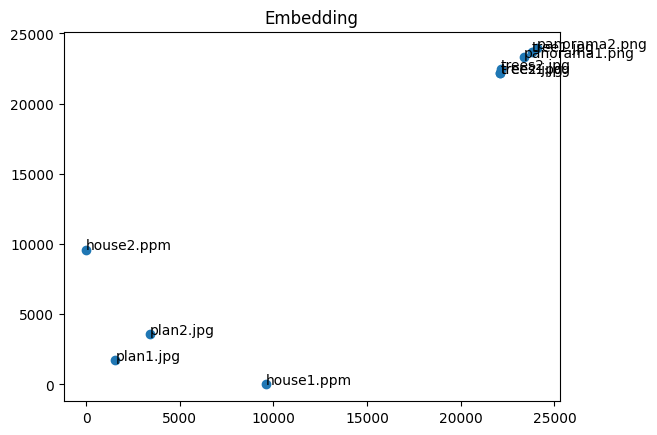

In [18]:
orb = cv2.ORB_create(edgeThreshold=0, nfeatures=50)

fichiers = charger_noms('list.txt')

PtDesc = [creer_dictionnaire(nom, orb, False) for nom in fichiers]

distances = np.zeros((len(PtDesc), len(PtDesc)))
for i in range(len(PtDesc)):
    for j in range(len(PtDesc)):
        distances[i, j], _, _ = dist_pts_interet(PtDesc[i], PtDesc[j])

noms = [os.path.basename(fichier) for fichier in fichiers]

afficher(distances, noms)


##  A Faire :
    - Utiliser une approche interactive pour le choix  des paramètres 
    - Visualisation en 3D 
    - Tester plusieurs métriques pour appariement (images) 
    - Utiliser différents descripteurs (images)
    - Ajouter plusieurs images dans la base ('list.txt') 
    - Comparaison des résultats

In [19]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

def afficher3D(distance, noms):
    nb = distance.shape[0]
    x = distance[:, 0]
    y = distance[:, 1]
    z = distance[:, 2]
    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', text=noms)])
    fig.show()
    

def afficher_avec_parametres(type_distance,visualisation, type_descripteur, pourcentage_points):
    
    if(type_descripteur == "ORB"):
        orb = cv2.ORB_create(edgeThreshold=0)
    elif(type_descripteur == "FAST"):
        orb = cv2.FastFeatureDetector_create()
    elif(type_descripteur == "KAZE"):
        orb = cv2.KAZE_create()
    elif(type_descripteur == "AKAZE"):
        orb = cv2.AKAZE_create()
    elif(type_descripteur == "BRISK"):
        orb = cv2.BRISK_create()
    elif(type_descripteur == "SIFT"):
        orb = cv2.SIFT_create()
    elif(type_descripteur == "GFTT"):
        orb = cv2.GFTTDetector_create()
    elif(type_descripteur == "SURF"):
        orb = cv2.SURF_create()
    else:
        raise ValueError("Mauvais type de descripteur")
    
    PtDesc = [creer_dictionnaire(nom, orb, False,pourcentage_points) for nom in fichiers]
        
    

    distances = np.zeros((len(PtDesc), len(PtDesc)))
    for i in range(len(PtDesc)):
        for j in range(len(PtDesc)):
            distances[i, j], _, _ = dist_pts_interet(PtDesc[i], PtDesc[j],type_distance)

    noms = [os.path.basename(fichier) for fichier in fichiers]

    if(visualisation == "2D"):
        afficher(distances, noms)
    else:
        afficher3D(distances, noms)

type_distance = widgets.Dropdown(
    options=["euclidean","hamming","jaccard","correlation","cosine","chebyshev","dice","hamming","jaccard","minkowski","seuclidean","sqeuclidean","yule"],
    value="euclidean",
    description="Type de distance"
)


visualisation = widget_Dropdown = widgets.Dropdown(
    options=["3D","2D"],
    value="2D",
    description="Visualisation"
)

type_widget = widgets.Dropdown(
    options=["HARRIS", "FAST", "ORB", "KAZE", "AKAZE", "BRISK", "SIFT", "GFTT", "SURF"],
    value="SIFT",
    description="Descripteurs"
)

pourcentage_points_widget = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=1,
    step=0.1,
    description="Pourcentage Points d'intérêt"
)


fichiers = charger_noms('list.txt')

interact(afficher_avec_parametres, type_distance=type_distance, visualisation=visualisation, type_descripteur=type_widget, pourcentage_points=pourcentage_points_widget)


interactive(children=(Dropdown(description='Type de distance', options=('euclidean', 'hamming', 'jaccard', 'co…

<function __main__.afficher_avec_parametres(type_distance, visualisation, type_descripteur, pourcentage_points)>

## Bonus : Vue panoramique : 

la composition de panorama, où nous avons deux images prises côte à côte avec un certain chevauchement, et nous voulons combiner ces deux images pour obtenir une composition panoramique. On peutle faire en trois étapes :

    1. Trouver des points d'intérêt dans les deux images.
    2. Pour chaque point caractéristique, trouver la paire correspondante dans l'autre image.
    3. Superposer les images de manière à aligner les paires aussi bien que possible.


![Panorama Stitching](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/panorama_stitching.png)


La partie difficile consiste à détecter les mêmes points de manière indépendante dans les deux images. Nous devons disposer de détecteurs de caractéristiques reproductibles, ce qui signifie que nous devons redétecter les mêmes caractéristiques d'une image dans une autre.
Deuxièmement, nous devons trouver de manière distinctive les caractéristiques correspondantes dans les deux images. Pour ce faire, nous utilisons des descripteurs. Les descripteurs sont une description d'un pixel et des caractéristiques autour de lui qui identifient de manière unique le pixel sans ambiguïté. Le descripteur doit être robuste aux changements géométriques et d'éclairage afin que nous puissions trouver le même descripteur dans une image différente. Ces changements géométriques peuvent être la translation, la rotation, la mise à l'échelle et les changements de perspective.

Un changement d'éclairage est une transformation affine simple de la valeur d'un pixel par un facteur constant B. Il peut facilement être surmonté en divisant une image par sa valeur d'intensité moyenne. 

L'invariance à la rotation est plus difficile à réaliser. Par exemple, nous pourrions toujours faire tourner nos caractéristiques détectées de telle sorte que les lignes les plus dominantes soient horizontales. Lorsque nous détectons des caractéristiques, nous avons généralement deux méthodes différentes : la détection de coin et la détection de blob. Un coin est une région de contraste qui change significativement dans deux directions perpendiculaires. Il a une précision de localisation très élevée mais est souvent difficile à distinguer. En revanche, un Blob est une région d'image qui diffère significativement de ses voisins - comme un petit motif dominant. Les blobs sont moins précis en termes de localisation que les coins, mais ils sont plus distincts et donc plus faciles à redétecter.






In [20]:

def matching2(img1, img2, keypoints1, keypoints2, points_matchs=100):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    matches = bf.match(keypoints1, keypoints2)
    
    matches = sorted(matches, key=lambda x: x.distance)
    
    return matches[:points_matchs]


def affichageFusion(pourcentage_points, nombre_points):

    panorama1 = cv2.imread('images/panorama1.png')
    panorama2 = cv2.imread('images/panorama2.png')

    panorama1_grise = cv2.cvtColor(panorama1, cv2.COLOR_BGR2GRAY)
    panorama2_grise = cv2.cvtColor(panorama2, cv2.COLOR_BGR2GRAY)

    detecteur = cv2.ORB_create()
    
    points_cles1, descripteurs1 = detecteur.detectAndCompute(panorama1_grise, None)
    points_cles2, descripteurs2 = detecteur.detectAndCompute(panorama2_grise, None)
    
    points1_cles = points_cles1[:int(pourcentage_points * len(points_cles1))]
    points2_cles = points_cles2[:int(pourcentage_points * len(points_cles2))]
    
    descripteurs1 = descripteurs1[:int(pourcentage_points * len(descripteurs1))]
    descripteurs2 = descripteurs2[:int(pourcentage_points * len(descripteurs2))]


    image1 = cv2.drawKeypoints(panorama1, points_cles1, None, flags=0)
    image2 = cv2.drawKeypoints(panorama2, points_cles2, None, flags=0)

    match = matching2(panorama1_grise, panorama2_grise, descripteurs1, descripteurs2, nombre_points)

    points1 = np.zeros((len(match), 2), dtype=np.float32)
    points2 = np.zeros((len(match), 2), dtype=np.float32)

    for i, match in enumerate(match):
        points1[i, :] = points_cles1[match.queryIdx].pt
        points2[i, :] = points_cles2[match.trainIdx].pt


    H, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

    panorama2_transforme = cv2.warpPerspective(panorama2, H, (panorama1.shape[1] + panorama2.shape[1], panorama1.shape[0]))
    panorama2_transforme[0:panorama1.shape[0], 0:panorama1.shape[1]] = panorama1

    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(panorama2_transforme, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    

pourcentage_points_widget = widgets.FloatSlider(
    value=0.1,
    min=0.1,
    max=1,
    step=0.1,
    description="Pourcentage Points d'intérêt"
)

type_widget = widgets.Dropdown(
    options=["ORB", "FAST", "KAZE", "AKAZE", "BRISK", "SIFT", "GFTT", "SURF"],
    value="ORB",
    description="Descripteurs"
)

nombre_points_widget = widgets.IntSlider(
    value=100,
    min=10,
    max=1000,
    step=10,
    description="Nombre de points"
)


interact(affichageFusion, pourcentage_points=pourcentage_points_widget, nombre_points=nombre_points_widget)


interactive(children=(FloatSlider(value=0.1, description="Pourcentage Points d'intérêt", max=1.0, min=0.1), In…

<function __main__.affichageFusion(pourcentage_points, nombre_points)>